<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/Updated-Code/Working%20Copy_of_Final_Assignment_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# Data Collection and Preprocessing


In [ ]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process

#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'StockPrice-Hybrid-Model-' already exists and is not an empty directory.


## Creation of Data Collection Functions

In [ ]:
# functions to Retrieve financial info and feature engineer
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

#Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

#Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

#Final preprocessing and rolling averages feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'].shift(-1))
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


In [ ]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)
print(full_finance.head(20))

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1414 non-null   datetime64[ns]
 1   open       1414 non-null   float64       
 2   high       1414 non-null   float64       
 3   low        1414 non-null   float64       
 4   close      1414 non-null   float64       
 5   adj_close  1414 non-null   float64       
 6   volume     1414 non-null   int64         
 7   ticker     1414 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 88.5+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

# Single Company Model Implementation
This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## EDA, Data Cleaning and Model Building
All data collection and initial prep is completed at this point.

In [ ]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
  #check for outstanding NA values
  print(df['score'].isna().sum())
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

### Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [ ]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)

print(sentiment_dfs[1].info())
print(df_list[1].info())
#create final dataframe with sentiment included
goog = pd.merge(df_list[1], sentiment_dfs[1], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
msft = pd.merge(df_list[0], sentiment_dfs[0], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
amzn = pd.merge(df_list[2], sentiment_dfs[2], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
tesla = pd.merge(df_list[3], sentiment_dfs[3], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
nflx = pd.merge(df_list[4], sentiment_dfs[4], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
print(goog.info())
frames = [goog, msft, amzn, tesla, nflx]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1410 non-null   datetime64[ns]
 1   score   1410 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 1414 to 2827
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1414 non-null   datetime64[ns]
 1   open        1414 non-null   float64       
 2   high        1414 non-null   float64       
 3   low         1414 non-null   float64       
 4   close       1414 non-null   float64       
 5   adj_close   1414 non-null   float64       
 6   volume      1414 non-null   int64         
 7   ticker      1414 non-null   object        
 8   target      1413 non-null   float64       
 9   10mda     

<ipython-input-11-8e39b6942336>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-11-8e39b6942336>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-11-8e39b6942336>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

### General EDA to Explore Change in Stock Prices and Daily Headlines

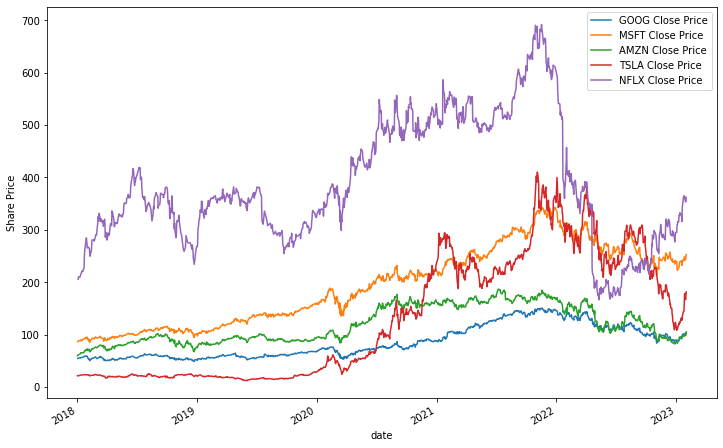

KeyError: ignored

In [ ]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (12, 8))

#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


### Scale Data and Configure Training/Test Datasets 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1]
data = data.drop(['ticker'],axis=1)
 
# features and target columns
print(data['target'])
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
print(target)
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 
train_split = 0.9
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_feat.index
 
X_train,X_test = X1[:split_idx],X1[split_idx:]
y_train,y_test = y1[:split_idx],y1[split_idx:]
X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
 
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

date
2018-01-03     87.110001
2018-01-04     88.190002
2018-01-05     88.279999
2018-01-08     88.220001
2018-01-09     87.820000
                 ...    
2023-01-26    248.160004
2023-01-27    242.710007
2023-01-30    247.809998
2023-01-31    252.750000
2023-02-01    264.600006
Name: target, Length: 1196, dtype: float64
[[0.00813638]
 [0.01232081]
 [0.0126695 ]
 ...
 [0.63076329]
 [0.64990317]
 [0.69581564]]
(1186, 10, 18) (1068, 10, 18) (118, 10, 18) (118, 1) (1068, 1)


### LSTM Model Architecture
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [ ]:
#LSTM Framework
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
#!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


34/34 [==============================] - 1s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
[0.0011851069284603, 0.0011851069284603]
{'n_hidden': 0, 'neurons_visible': 58, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 50, 'dropout2': 0.7, 'neurons_hidden2': 40, 'dropout3': 0.4, 'neurons_hidden3': 50}


## LSTM Model Testing

### Format Test Data to Reflect Training Data Format

In [ ]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(google_score))

### Evaluate LSTM Model Success on Test Data

In [ ]:
#test LSTM model using x_test and google test data
from keras.models import load_model
model = load_model(LSTM_model.h5)

## Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [ ]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')

Saving finance.csv to finance.csv


In [ ]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data

In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### Forecasting with Prophet

In [ ]:
# We use the best parameter to fit the model
final_model = Prophet(**best_params)
final_model.fit(data_preparation(MSFT_Data))

In [ ]:
future = final_model.make_future_dataframe(periods=100)
validation_predict = final_model.predict(future)
print(validation_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
fig = final_model.plot(validation_predict)
fig1 = final_model.plot_components(validation_predict)

## Hybrid Model 

### Define Training Data Using Ouputs from Standalone Models

In [ ]:
#combine prophet and lstm results into metamodel training set, keeping microsoft validation data separate


In [ ]:
#Hybrid model architecture and training
LR = 0.01
hybrid = Sequential()
hybrid.add(LSTM(units = 8, activation = "relu", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = True))
hybrid.add(Dropout(0.5))
hybrid.add(LSTM(units = 12, activation = 'relu', return_sequences = True))
hybrid.add(Dropout(0.5))
hybrid.add(LSTM(units = 12))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = [Precision, "mean_squared_error"])
Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
hybrid.fit(X_train2, Y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])
hybrid.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

### Hybrid Model Testing

In [ ]:
#Make predictions on the held out microsoft data (y_test) and google test data
predictions = hybrid.predict(X_test2)
y_pred = np.round(predictions).flatten()

In [ ]:
# THIS BLOCK IS BEING EDITED


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# this function is used to visualize the classification of the model prediction
def confusion_matrix_plot(y_test,y_pred):
  """
    Params: y_test: the target
            y_pred: the predicted values

    
    Returns: 1: a plot of the confucsion matrix
             2: a classification report 
          

  """
  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(cm,cmap=plt.cm.Blues)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
  plt.show()

  print("\n---------------------Classification Report-----------------------")
  return print(classification_report(y_test,y_pred))

# Multiple Company Model

## Generate Sub-models

In [ ]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in list_of_df:
    data = frames[i]
    score = data['score']
    target = data['target']
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    scaler = MinMaxScaler()
    for col in training.columns:
      training[col] = scaler.fit_transform(training[col])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, 10)
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train, ticker):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 8, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True))
    hybrid.add(Dropout(0.5))
    hybrid.add(LSTM(units = 12, activation = 'relu', return_sequences = True))
    hybrid.add(Dropout(0.5))
    hybrid.add(LSTM(units = 12))
    hybrid.add(Dropout(0.5))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames)
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(tick, x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/Models/'+tick+'_lstm.h5')


## Configure Hybrid Training Set and Train Hybrid Model

In [ ]:
import os
def hybrid_train(direct, ticker_list, hybrid_train):
    preds_dict = {}
    path = direct
    for num, model in enumerate(os.listdir(path)):
        model = load_model(model)
        prediction = model.predict(hybrid_train)
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DatFrame(preds_dict)
    return preds_df

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data =  hybrid_train('/content/StockPrice-Hybrid-Model-/Models/', ticker_list, X_train) 
hybrid_expanded = multiple_models(hybrid_training_data, y_train)

## Test the Expanded Model

In [ ]:
from os import listdir
google_test = {}
microsoft_test = {}
path = '/models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(model)
  goog_preds = model.predict(google_ft)
  micro_preds = model.predict(X_test)
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)